In [1]:
!git clone https://pattoken@github.com/sinhajiya/Face_Recognition_from_Features_using_Yale_Face_Database.git

Cloning into 'Face_Recognition_from_Features_using_Yale_Face_Database'...
remote: Enumerating objects: 1232, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 1232 (delta 95), reused 315 (delta 95), pack-reused 916 (from 1)
Receiving objects: 100% (1232/1232), 58.88 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (559/559), done.
Updating files: 100% (1325/1325), done.


In [2]:
!git config --global user.email "emailid"
!git config --global user.name "username"

## Importing and Initializing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from scipy.ndimage import convolve
import requests

In [ ]:
data_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/data"
sample_img = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/data/subject01.centerlight"
normalized_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/normalized_data"

In [ ]:
subject = []
emotions = ['centerlight', 'happy', 'leftlight', 'glasses', 'normal',
                'rightlight', 'sad', 'sleepy', 'surprised', 'wink','noglasses']
for i in range (1,16):
  subject.append(f"subject0{i}")

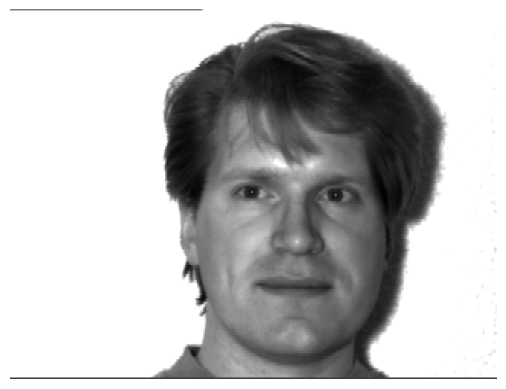

In [ ]:
img = Image.open(sample_img)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
type(img)

PIL.GifImagePlugin.GifImageFile

In [ ]:
img_ndarray = np.asarray(img)
img_ndarray.shape

(243, 320)

In [ ]:
(img_ndarray.min(),img_ndarray.max())

(9, 255)

In [ ]:
def get_array(subject_id, expression, directory):
    target_filename = f"subject{subject_id}.{expression}"

    for filename in os.listdir(directory):
        if filename == target_filename:
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                img_ndarray = np.asarray(img)
                return img_ndarray

            except IOError:
                print(f"Cannot open file: {filepath}")

    print(f"File {target_filename} not found in directory.")
    return None

# Image Visualization and Preprocessing

1. Look at the data
2. Distribution of images and expressions.
3. Image Histogram (for pixel values)
4. Check if all of them are of same size. If not, resize.


## Data Visualization

In [ ]:
def show_data(subject_id):
    # Initialize list to store images.
    images = []
     # Load images for the specified subject
    for emotion in emotions:
        filename = f'subject{subject_id}.{emotion}'
        filepath = os.path.join(data_dir, filename)
        try:
            img = Image.open(filepath)  #Data type of img: PIL.GifImagePlugin.GifImageFile
            images.append(img)
        except FileNotFoundError:
            print(f"File not found: {filepath}")

    # Define the grid size for visualization
    grid_size = (3,4)

    # Create a new figure
    plt.figure(figsize=(15,12))

    # Plot each image
    for i, img in enumerate(images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(img, cmap='gray')  # Show image in grayscale
        plt.axis('off')
        plt.title(f'{emotions[i]}', fontsize=10)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.suptitle(f"Images of Subject {subject_id}", fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()


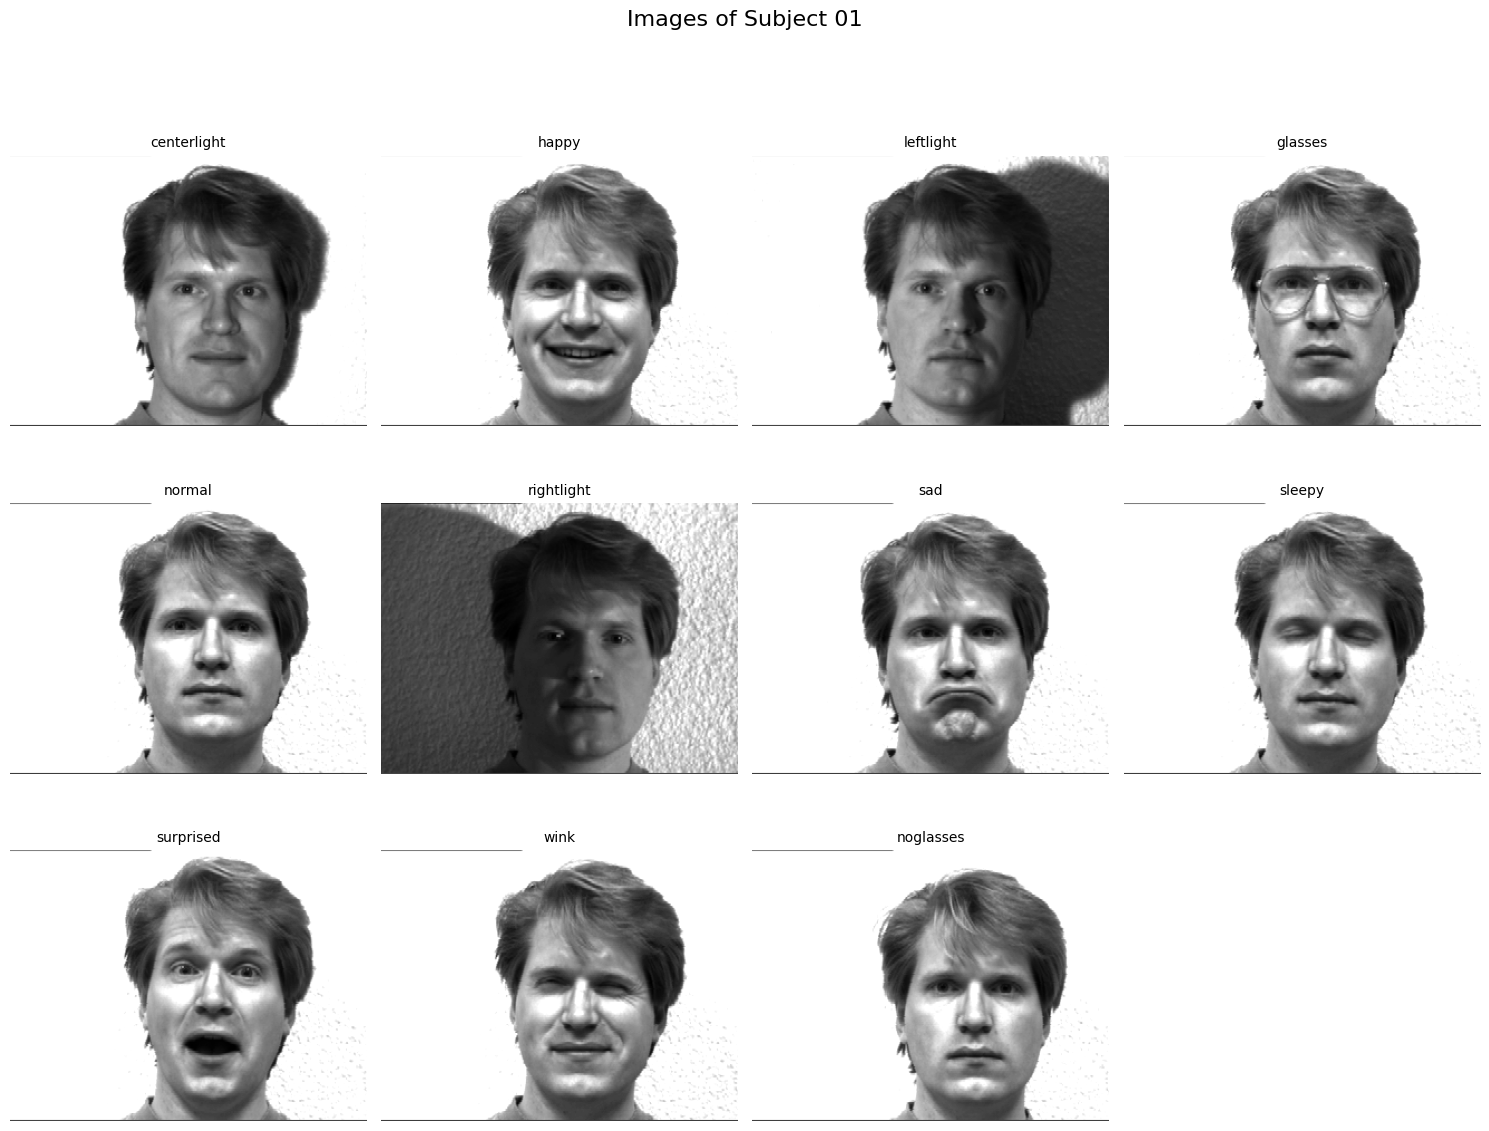

In [ ]:
show_data(subject_id='01')

## Distribution of data


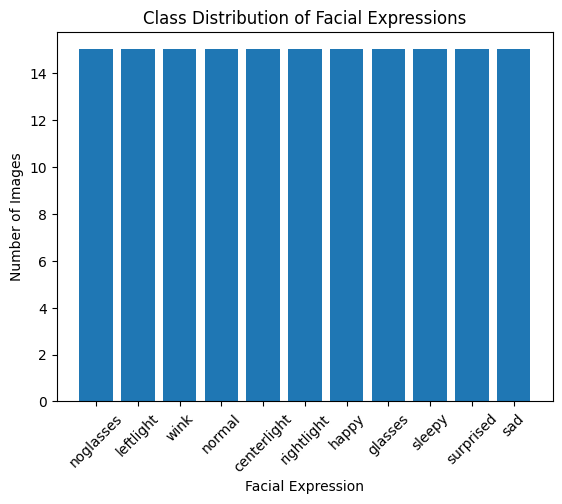

In [ ]:
expression_counts = {}

for filename in os.listdir(data_dir):
    expression = filename.split('.')[1]
    if expression in expression_counts:
        expression_counts[expression] += 1
    else:
        expression_counts[expression] = 1


plt.bar(expression_counts.keys(), expression_counts.values())
plt.xlabel('Facial Expression')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Facial Expressions')
plt.xticks(rotation=45)
plt.show()


## Image Histogram

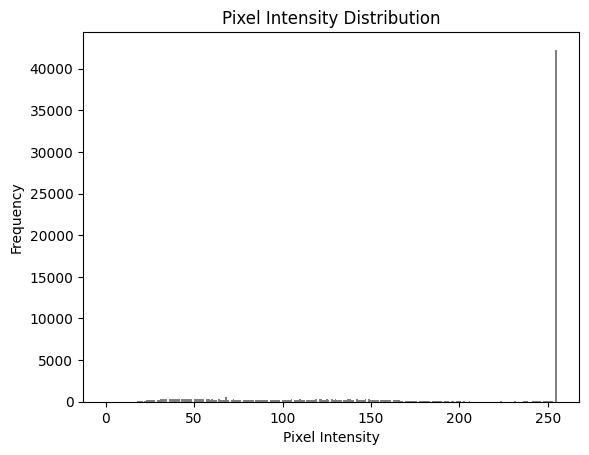

In [ ]:
pixel_values = []

img = Image.open("/content/Face_Recognition_from_Features_using_Yale_Face_Database/data/subject01.centerlight")
img_np = np.array(img)
pixel_values.extend(img_np.ravel())  #.ravel() changes the image array to a 1D array.
                                         #.extend() adds each individual pixel value from the flattened array to the pixel_values list.

plt.hist(pixel_values, bins=256, range=(0, 255), color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Maximum pixel values have a pixel value of 255.

## Check if all the images are of same size

In [ ]:
def isSameSize(directory):

    sizes = set()  # Use a set to store unique sizes

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                sizes.add(img.size)  # Add size (width, height) to the set
        except IOError:
            print(f"Cannot open file: {filepath}")

    if len(sizes) == 1:  #since sizes is a set, it will not store duplicates.
        # All images have the same size
        size = sizes.pop()  # Get the unique size
        print(f"All the images are of size. \nThe size is {size}")
    else:
        # Images have different sizes
        return False, None



In [ ]:
isSameSize(data_dir)

All the images are of size. 
The size is (320, 243)


Also, here we can see that the images are grayscale (since the size is in form (h,w))

## Normalization

Normalization helps improve the performance and convergence speed of machine learning algorithms.
Normalizing the pixel values to [0,1]

In [ ]:
def normalize_image(directory, output_directory):

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                img_ndarray = np.asarray(img, dtype=np.float32)
                img_ndarray = img_ndarray.copy()
                img_ndarray /= 255.0

            output_filepath = os.path.join(output_directory, f"{filename}.npy")
            np.save(output_filepath, img_ndarray)

        except IOError:
            print(f"Cannot open file: {filepath}")


    return True

This function normalizes the image and stores in the folder named normalized_dir.

In [ ]:
normalize_image(data_dir,normalized_dir)

True

## Opening Normalized Image

In [ ]:
def processed_img(subject_id, expression, directory):
    target_filename = f"subject{subject_id}.{expression}.npy"

    for filename in os.listdir(directory):
        if filename == target_filename:
            filepath = os.path.join(directory, filename)
            try:
                # Load the numpy array
                img_ndarray = np.load(filepath)
                return img_ndarray  # Return the loaded array once found

            except IOError:
                print(f"Cannot open file: {filepath}")

    print(f"File {target_filename} not found in directory.")
    return None  # Return None if no matching file is found

In [ ]:
img_ndarray = processed_img("02", "happy", normalized_dir)

In [ ]:
(img_ndarray.min(),img_ndarray.max())

(0.0, 1.0)

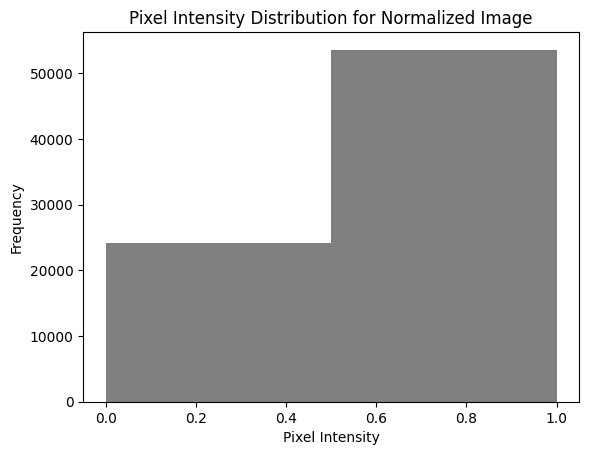

In [ ]:
img_np = np.load('/content/Face_Recognition_from_Features_using_Yale_Face_Database/normalized_data/subject01.centerlight.npy')

pixel_values = []
pixel_values.extend(img_np.ravel())  #.ravel() changes the image array to a 1D array.
                                         #.extend() adds each individual pixel value from the flattened array to the pixel_values list.

plt.hist(pixel_values, bins=2, range=(0, 1), color='gray')
plt.title('Pixel Intensity Distribution for Normalized Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
%cd Face_Recognition_from_Features_using_Yale_Face_Database

/content/Face_Recognition_from_Features_using_Yale_Face_Database


In [ ]:
!git add .
!git commit -m "06/11"
!git push origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


# Feature Extraction

1. Local Binary Pattern
2. Gabor filter
3. Laplacian of Gaussian (LoG)
4. Gray-Level Co-occurrence Matrix (GLCM)


## Local Binary Pattern

### Theory

 Local Binary Patterns (LBPs) method relies on feature extraction for face recognition.

 [2004_Ahonen]
 The face area is first divided into small regions from which Local Binary Pattern (LBP) histograms are extracted and concatenated into a single, spatially enhanced feature histogram efficiently representing the face image. Considers both shape and texture information to represent the face images. The textures of the facial regions are locally encoded by the LBP patterns while the whole shape of the face is recovered by the construction of the face feature histogram. The idea behind using the LBP features is that the face images can be seen as composition of micro-patterns which are invariant with respect to monotonic grey scale transformations. Combining these micro-patterns, a global description of the face image is obtained. By dividing the image into cells we can introduce locality into our final feature vector.

 1.  For neighbourhoods we will use the notation (P,R) which means P sampling points on a circle of radius of R.
 2. A Local Binary Pattern is called uniform if it contains at most two bitwise transitions from 0 to 1 or vice versa when the binary string is considered circular. For example, 00000000, 00011110 and 10000011 are uniform patterns.Uniform patterns tend to capture the most essential texture features, as they correspond to simple, fundamental shapes like edges or corners.This reduces the number of patterns to be considered, which can make the LBP more efficient by grouping similar texture structures and simplifying the analysis. For example, in a typical 8-neighbor LBP setting, there are 256 possible binary patterns, but only 58 are uniform, allowing for a much more compact representation of texture features.


![LBP.png](attachment:LBP.png)    

### Code

In [ ]:
from skimage.feature import local_binary_pattern

In [ ]:
# Directories for LBP histograms and full LBP features
lbp_features_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/lbp_features"
lbp_full_features_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/lbp_full_features"
if not os.path.exists(lbp_features_dir):
    os.makedirs(lbp_features_dir)
if not os.path.exists(lbp_full_features_dir):
    os.makedirs(lbp_full_features_dir)

In [ ]:
# Function to extract LBP features as histogram and full LBP array
def lbp_features(image, radius=1, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
# The "uniform" method in the local_binary_pattern function refers to a special
# LBP variant that reduces the dimensionality of the LBP feature vector while preserving the most important texture information.
# Extract histogram of LBP patterns to make feature vectors comparable, independent of image size.
    n_bins = int(lbp.max() + 1)
    # . ravel(): Flattens the LBP array to a 1D array
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp, lbp_hist

# Process all files in the normalized_data directory
for filename in os.listdir(normalized_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(normalized_dir, filename)
        image = np.load(file_path)

        # Extract LBP features
        lbp, lbp_hist = lbp_features(image)

        # Save the LBP histogram
        lbp_hist_path = os.path.join(lbp_features_dir, f"{filename}_lbp_hist.npy")
        np.save(lbp_hist_path, lbp_hist)

        # Save the full LBP feature array
        lbp_full_path = os.path.join(lbp_full_features_dir, f"{filename}_lbp.npy")
        np.save(lbp_full_path, lbp)

        print(f"Processed and saved LBP histogram and full LBP array for {filename}")


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed and saved LBP histogram and full LBP array for subject04.noglasses.npy
Processed and saved LBP histogram and full LBP array for subject09.normal.npy
Processed and saved LBP histogram and full LBP array for subject12.leftlight.npy
Processed and saved LBP histogram and full LBP array for subject12.normal.npy
Processed and saved LBP histogram and full LBP array for subject01.wink.npy
Processed and saved LBP histogram and full LBP array for subject11.rightlight.npy
Processed and saved LBP histogram and full LBP array for subject13.sleepy.npy
Processed and saved LBP histogram and full LBP array for subject06.surprised.npy
Processed and saved LBP histogram and full LBP array for subject03.surprised.npy
Processed and saved LBP histogram and full LBP array for subject04.wink.npy
Processed and saved LBP histogram and full LBP array for subject01.happy.npy
Processed and saved LBP histogram and full LBP array for subject10.happy.npy
Processed and saved LBP histogram and full LBP array f

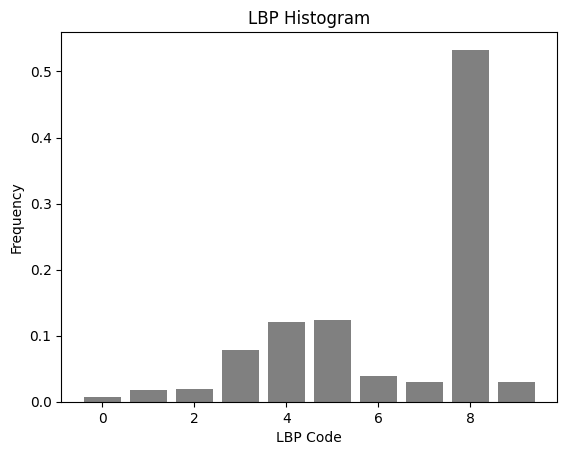

In [ ]:
# Load the LBP pattern and histogram from the saved files
lbp_pattern_path = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/lbp_features/subject01.centerlight.npy_lbp_hist.npy"
# lbp_histogram_path = lbp_pattern_path.replace("_lbp.npy", "_hist.npy")  # Assuming histogram saved as separate file

# Load LBP pattern and histogram
lbp_pattern = np.load(lbp_pattern_path)
# lbp_hist = np.load(lbp_histogram_path)


plt.bar(range(len(lbp_pattern)), lbp_pattern, color='gray')
plt.title("LBP Histogram")
plt.xlabel("LBP Code")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# VISUALIZE HOW THE LBP FEATURE VECTOR LOOKS LIKE
lbp = np.load("/content/Face_Recognition_from_Features_using_Yale_Face_Database/lbp_full_features/subject01.centerlight.npy_lbp.npy")
lbp.shape


(243, 320)

In [ ]:
img_ndarray.shape


(243, 320)

## Gabor Filter

### Theory

A **Gabor filter** is a linear convolution filter that combines a **Gaussian function** (providing a spatial weighting) with a **sinusoidal plane wave** (defining the oscillatory component). It is widely used for edge and texture detection due to its ability to capture both spatial localization (via the Gaussian) and frequency (via the sinusoid).

- The **Gaussian component** controls the smoothness and localization of the filter, ensuring that nearby pixels contribute more heavily to the response.
- The **sinusoidal component** introduces the oscillations that make the filter sensitive to specific frequencies and orientations.

This filter can capture edge information in different orientations and scales by adjusting parameters such as frequency and orientation. Specifically:
- **At theta = 90°**, the filter detects **vertical edges**.
- **At theta = 45°**, it detects **diagonal edges** at that angle.

**Gabor filters are well-suited to tasks like texture analysis** and **feature extraction** because they can capture variations in intensity (grayscale pixel values) across multiple orientations and scales. They are especially effective for analyzing **local structure** and **directionality** in images, providing a detailed representation of spatial frequency content.

![alt text](https://github.com/sinhajiya/Face_Recognition_from_Features_using_Yale_Face_Database/blob/main/image.png?raw=1)



**Spatial Aspect Ratio (γ)**  refers to the ellipticity or shape of the Gaussian envelope of the filter. It controls how stretched or squashed the filter is in one direction compared to another.
It helps control the shape of the Gabor filter, which is useful when detecting specific features in an image.
Elongated Gabor filters can be tuned to detect edges or textures in a particular direction with higher sensitivity.
Circular Gabor filters are more general-purpose and work equally well in all directions.

**λ (Wavelength)**: Defines the distance over which the sine wave repeats, controlling the scale of the filter. Smaller λ detects finer details, while larger λ captures coarser patterns.
**θ (Orientation):** Specifies the direction of the filter's sensitivity, determining which edges or patterns (horizontal, vertical, or diagonal) will be detected.

**ψ (Phase Offset):** Shifts the sine wave, affecting the alignment of the filter. It controls whether the Gabor filter detects features like edges or textures with varying light and dark regions.

At ψ = 0, the wave starts at the zero-crossing point (similar to a cosine wave). The filter will primarily detect even-symmetric features, such as edges where there is a clear transition from dark to light or vice versa (e.g., vertical and horizontal edges).

At ψ = π/2, the wave starts at its peak or trough (similar to a sine wave). The filter will primarily detect odd-symmetric features, such as transitions where there is an alternation of light and dark regions (e.g., texture patterns with stripes).

**σ (Standard Deviation):** Determines the width of the Gaussian envelope, controlling how localized or spread out the filter is in space. A larger σ makes the filter broader and captures larger features.

### Code

In [ ]:
from skimage.filters import gabor_kernel

In [ ]:
def extract_gabor(image, lambdas=[10, 20, 30], thetas=[0, np.pi/4, np.pi/2]):
    features = []
    psi = 0    # Phase offset
    sigma = 4  # Standard deviation
    gamma = 0.5 # Spatial aspect ratio

    for wavelength in lambdas:
        for theta in thetas:
            gabor_kern = gabor_kernel(frequency=1.0/wavelength,theta=theta, sigma_x=sigma,sigma_y=sigma/gamma,offset=psi)

            # Apply the filter to the image
            conv_result = convolve(image, np.real(gabor_kern))

            # Extract mean and variance of the filter responses as features
            mean_real = np.mean(conv_result)
            var_real = np.var(conv_result)

            features.append(mean_real)
            features.append(var_real)

    return np.array(features)



In [ ]:
gabor_dir = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/gabor_features"
if not os.path.exists(gabor_dir):
    os.makedirs(gabor_dir)

In [ ]:
for filename in os.listdir(normalized_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(normalized_dir, filename)
        image = np.load(file_path)
        gabor_features = extract_gabor(image)

        gabor_save_path = os.path.join(gabor_dir, f"{filename}_gabor.npy")
        np.save(gabor_save_path, gabor_features)

KeyboardInterrupt: 

18 values of mean and variance (9 each) for each combination of wavelength and thetas.

For facial recognition, these features provide rich information about the spatial frequency and directionality of face textures, making them robust to variations in lighting and facial orientation.

For a Gabor filter with a specific orientation (say 45°) and frequency, the mean might tell you how strong the edges are in that direction (e.g., how prominent the facial features like the jawline or cheekbones are).

The variance could tell you how much variability or detail exists along that edge (e.g., smooth jawline vs. a more detailed texture in the region of wrinkles).

### Visualize

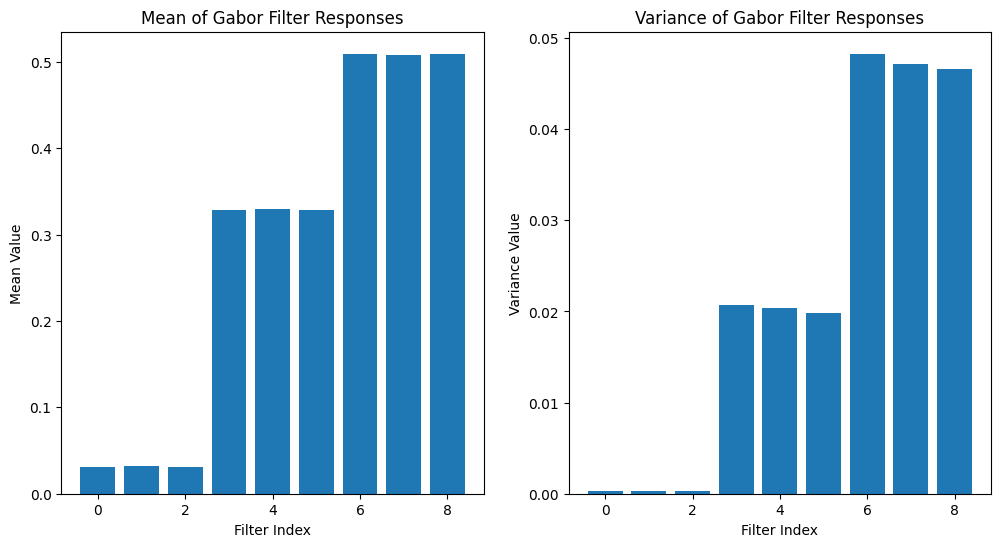

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a file from the directory to visualize
gabor_file = "/content/Face_Recognition_from_Features_using_Yale_Face_Database/gabor_features/subject01.centerlight.npy_gabor.npy"  # Example file

# Load the precomputed Gabor features
gabor_features = np.load(gabor_file)

# Visualize the features
# Assuming each Gabor filter output was summarized by its mean and variance
num_filters = len(gabor_features) // 2  # Dividing by 2 because each filter has mean and variance
means = gabor_features[::2]
variances = gabor_features[1::2]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(range(num_filters), means)
ax[0].set_title("Mean of Gabor Filter Responses")
ax[0].set_xlabel("Filter Index")
ax[0].set_ylabel("Mean Value")

ax[1].bar(range(num_filters), variances)
ax[1].set_title("Variance of Gabor Filter Responses")
ax[1].set_xlabel("Filter Index")
ax[1].set_ylabel("Variance Value")

plt.show()


In [ ]:
!pip install nbmerge

  Preparing metadata (setup.py) ... done
  Created wheel for nbmerge: filename=nbmerge-0.0.4-py2.py3-none-any.whl size=6393 sha256=2c8546e73f1a3d85cc029912dc174acf43d249d9fffbd6aca87009732cf68e8e
  Stored in directory: /root/.cache/pip/wheels/ab/6a/28/a33b228ce3eda9a7cc2cfd050b24752d09ac76a13733738df5
Successfully built nbmerge


In [ ]:
nbmerge file_1.ipynb file_2.ipynb file_3.ipynb > merged.ipynb

## Laplacian of Gaussian (LOG)

LoG is used for edge detection and blob detection in images

sigma: Controls the scale of Gaussian smoothing before applying the Laplace filter.

The features extracted are the mean and variance of the LoG responses.

### Code

In [ ]:
from skimage.filters import laplace, gaussian

In [ ]:
def extract_log(image, sigma=1.0):
    smoothed_image = gaussian(image, sigma=sigma)
    log_image = laplace(smoothed_image)
    plt.imshow(log_image, cmap="gray")
    plt.axis("off")
    plt.title("The LoG image")
    mean_log = np.mean(log_image)
    var_log = np.var(log_image)

    return np.array([mean_log, var_log])


In [ ]:
extract_log(img_ndarray,1.0)

## Gray-Level Co-occurrence Matrix (GLCM)

### Theory

GLCM is used for texture analysis based on pixel spatial relationships.
Explanation:
distances: List of pixel distances for GLCM computation

angles: List of angles for GLCM (e.g., 0, 45, 90, 135 degrees).

properties: The texture properties you want to extract (e.g., contrast, correlation, energy, and homogeneity).

### Code

In [ ]:
from skimage.feature import graycomatrix, graycoprops

In [ ]:
def extract_glcm(image, distances=[1], angles=[0], properties=['contrast', 'correlation', 'energy', 'homogeneity']):

    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract GLCM properties
    features = []
    for prop in properties:
        feature = graycoprops(glcm, prop)
        features.append(feature.mean())

    return np.array(features)


# Combining the features

After extracting all the features from each image, concatenate them to form a single feature vector for the image.

In [ ]:
def extract_all_features(image):
    # Extract different features
    lbp_features = extract_lbp(image)
    gabor_features = extract_gabor(image)
    log_features = extract_log(image)
    glcm_features = extract_glcm(image)

    # Combine all features into a single feature vector
    feature_vector = np.hstack([lbp_features, gabor_features, log_features, glcm_features])

    return feature_vector


## Next Steps:

    Loop through all preprocessed images, apply the feature extraction methods, and save the features for each image.
    Store the extracted features in a format (e.g., NumPy arrays, .csv, or .txt files) suitable for machine learning models.

# Applying ML models

Model for classification:   

1. SVM
2. Random Forest Classifier
3. kNN Classifier

# Metrics of the model